# Introduction

Matplotlib is built on top of a transformation framework to easily move between coordinate systems, 
* userland data coordinate system
* axes coordinate system
* figure coordinate system
* display coordinate system

This module will also cover 
* other transformation objects, e.g. `bbox`
* transformation in handling digital `Image`
* transformation in `Legend`

In [1]:
import copy
import datetime
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from IPython.display import display

# *transforms*

The [transforms tutorial](https://matplotlib.org/3.5.0/tutorials/advanced/transforms_tutorial.html) should be clear enough to explain the basics.

Individual transforms categorized by coordinate systems

| Coordinates      | Transformation object                                  | Description                                                  |
| ---------------- | ------------------------------------------------------ | ------------------------------------------------------------ |
| "data"           | `ax.transData`                                         | The coordinate system for the data, controlled by xlim and ylim. |
| "axes"           | `ax.transAxes`                                         | The coordinate system of the [`Axes`](https://matplotlib.org/3.5.0/api/axes_api.html#matplotlib.axes.Axes); (0, 0) is bottom left of the axes, and (1, 1) is top right of the axes. |
| "subfigure"      | `subfigure.transSubfigure`                             | The coordinate system of the [`SubFigure`](https://matplotlib.org/3.5.0/api/figure_api.html#matplotlib.figure.SubFigure); (0, 0) is bottom left of the subfigure, and (1, 1) is top right of the subfigure. If a figure has no subfigures, this is the same as `transFigure`. |
| "figure"         | `fig.transFigure`                                      | The coordinate system of the [`Figure`](https://matplotlib.org/3.5.0/api/figure_api.html#matplotlib.figure.Figure); (0, 0) is bottom left of the figure, and (1, 1) is top right of the figure. |
| "figure-inches"  | `fig.dpi_scale_trans`                                  | The coordinate system of the [`Figure`](https://matplotlib.org/3.5.0/api/figure_api.html#matplotlib.figure.Figure) in inches; (0, 0) is bottom left of the figure, and (width, height) is the top right of the figure in inches. |
| "display"        | `None`, or `IdentityTransform()`                       | The pixel coordinate system of the display window; (0, 0) is bottom left of the window, and (width, height) is top right of the display window in pixels. |
| "xaxis", "yaxis" | `ax.get_xaxis_transform()`, `ax.get_yaxis_transform()` | Blended coordinate systems; use data coordinates on one of the axis and axes coordinates on the other. |

# advanced transforms

more individual (Affine2D) transforms
* AffineDeltaTransform <br/>
  Transform displacements between points
* ScaledTranslation <br/>
  A transformation that translates by xt and yt, after xt and yt have been transformed by scale_trans. `offset_copy` is a helper transform function with an added offset (*data* transform + *units* offset)

Note: other affine2D transforms have been embedded into methods of `Affine2D` transforms, e.g. `rotate_deg`, `skew_deg`, `scale`. (see [examples](https://matplotlib.org/3.5.0/gallery/images_contours_and_fields/affine_image.html#sphx-glr-gallery-images-contours-and-fields-affine-image-py)). There is a reason we need to separate displacements and translation rather than as methods embedded in `Affine2D` transforms: coordinate-system based transforms (some) are not `Affine2D` subclasses, rather composite/blended based, thus not having these methods so we need to have separate class to help make basic displacements/translations.

multi-party transform
* blended (Affine2D) by `blended_transform_factory` <br/>
    Basically it's a transform to let x axis and y axis to use different coordinate systems. This blended transform has been embeded in some of the convenience module methods, e.g. `axvline`, `axhspan`, `axvspan`
    * blended generic transform (rarely used) <br/>
      blended generic (not limited to affine2D) transform
* composite (Affine2D) & cancellation by operator overloading <br/>
    Basically it's a pipelined transform, 
    * composite transformation pipeline A + B returns a transform C so that C.transform(x) == B.transform(A.transform(x)). e.g. scaled translation first and then rotation for an object.
    * cancellation transformation pipeline A - B means A + B.inverted()
    * composite generic transform (rarely used) <br/>
      composite generic (not limited to affine2D) transform

others
* other transforms not in the sense of pure mathmematical Affine transformation
    * `Bbox` (*points*, **kwargs)
    * `BboxTransform` (*boxin*, *boxout*, **kwargs)
    * `BboxTransformFrom` (*boxin*, **kwargs) <br/>
      BboxTransformFrom linearly transforms points from a given Bbox to the unit bounding box. This is the transform as `ax.transLimits` is using. for completeness, transforms from data coordinate system to display coordinate system are decomposed into the following pipeline transforms *self.transData = self.transScale + (self.transLimits + self.transAxes)*
    * `BboxTransformTo` (*boxout*, **kwargs) <br/>
      BboxTransformTo is a transformation that linearly transforms points from the unit bounding box to a given Bbox.
    * `LockableBbox` (*bbox*, *x0=None*, *y0=None*, *x1=None*, *y1=None*, **kwargs) <br/>
      immutable version of `Bbox`
    * `TransformedBbox` (*bbox*, *transform*, **kwargs) <br/>
      See [example](https://matplotlib.org/3.5.0/gallery/images_contours_and_fields/demo_bboximage.html?highlight=transformedbbox)
    * `TransformedPatchPath` (*patch*)
    * `TransformedPath` (*path*, *transform*)
    
Note: `bbox` serves both transforms and patches. some useful usage would be getting `Axes.bbox` as transforms in the following example (see [Annotating Plots](https://matplotlib.org/3.5.0/gallery/text_labels_and_annotations/annotation_demo.html) for more details)
```python
from matplotlib.text import OffsetFrom
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.annotate('xy=(0.8, 0.5)\nxycoords=ax1.transData',
             xy=(0.8, 0.5), xycoords=ax1.transData,
             xytext=(10, 10),
             textcoords=OffsetFrom(ax2.bbox, (0, 0), "points"),
             ha="left", va="bottom",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax2.set(xlim=[-2, 2], ylim=[-2, 2])
plt.show()
```

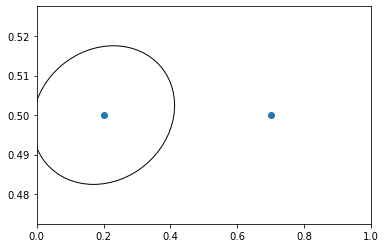

In [2]:
fig, ax = plt.subplots()
xdata, ydata = (0.2, 0.7), (0.5, 0.5)
ax.plot(xdata, ydata, "o")
ax.set_xlim((0, 1))

trans = (fig.dpi_scale_trans +
         mtrans.ScaledTranslation(xdata[0], ydata[0], ax.transData))

# plot an ellipse around the point that is 150 x 130 points in diameter...
circle = mpatches.Ellipse((0, 0), 150/72, 130/72, angle=40,
                          fill=None, transform=trans)
ax.add_patch(circle)
plt.show()

In [3]:
pprint({
    'ax.transData': ax.transData,
    'ax.transAxes': ax.transAxes,
    'fig.transFigure': fig.transFigure, 
    'fig.dpi_scale_trans': fig.dpi_scale_trans,
    'ax.get_xaxis_transform': ax.get_xaxis_transform(),
    'ax.get_yaxis_transform': ax.get_yaxis_transform(),
})

{'ax.get_xaxis_transform': <matplotlib.transforms.BlendedGenericTransform object at 0x120a46580>,
 'ax.get_yaxis_transform': <matplotlib.transforms.BlendedGenericTransform object at 0x120a465b0>,
 'ax.transAxes': <matplotlib.transforms.BboxTransformTo object at 0x120a46310>,
 'ax.transData': <matplotlib.transforms.CompositeGenericTransform object at 0x120a46610>,
 'fig.dpi_scale_trans': <matplotlib.transforms.Affine2D object at 0x120a39130>,
 'fig.transFigure': <matplotlib.transforms.BboxTransformTo object at 0x120a39a30>}


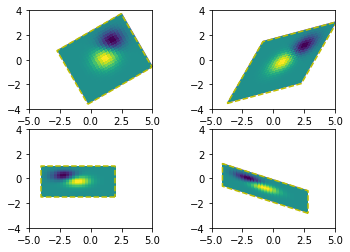

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms


def get_image():
    delta = 0.25
    x = y = np.arange(-3.0, 3.0, delta)
    X, Y = np.meshgrid(x, y)
    Z1 = np.exp(-X**2 - Y**2)
    Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
    Z = (Z1 - Z2)
    return Z


def do_plot(ax, Z, transform):
    im = ax.imshow(Z, interpolation='none',
                   origin='lower',
                   extent=[-2, 4, -3, 2], clip_on=True)

    trans_data = transform + ax.transData
    im.set_transform(trans_data)

    # display intended extent of the image
    x1, x2, y1, y2 = im.get_extent()
    ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--",
            transform=trans_data)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-4, 4)


# prepare image and figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
Z = get_image()

# image rotation
do_plot(ax1, Z, mtransforms.Affine2D().rotate_deg(30))

# image skew
do_plot(ax2, Z, mtransforms.Affine2D().skew_deg(30, 15))

# scale and reflection
do_plot(ax3, Z, mtransforms.Affine2D().scale(-1, .5))

# everything and a translation
do_plot(ax4, Z, mtransforms.Affine2D().
        rotate_deg(30).skew_deg(30, 15).scale(-1, .5).translate(.5, -1))

plt.show()